## Import python modules

In [15]:
import matplotlib.pyplot as plt
from environment.general_env import GeneralEnv, GymToGymnasium
from environment.cee_us_env.fpp_construction_env import FetchPickAndPlaceConstruction

## Construct a environment and visualize it

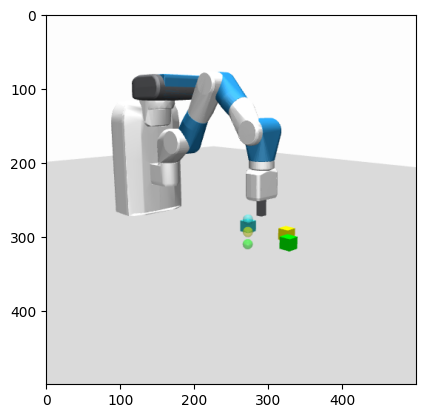

In [16]:
env_name = "pickplace3"
block_num = 3
render = False
env = GymToGymnasium(
    FetchPickAndPlaceConstruction(
        name=env_name,
        sparse=False,
        shaped_reward=False,
        num_blocks=block_num,
        reward_type='sparse',
        case = 'Singletower',
        visualize_mocap=False,
        stack_only=True,
        simple=True
    ), 
    render_mode='human' if render else 'rgb_array'
)

state, _ = env.reset()
plt.imshow(env.render())


## Observation Space and Action Space

The action space of the this environment is of length 4 and in the format of [dx, dy, dz, gripper]. dx, dy, dz indicates the displacement of the ebnd effector in the x,y,z dimention. Gripper represents the action of the end effector: openning or closing the end effector.

For further info about the action space, check out https://robotics.farama.org/envs/fetch/push/#action-space 


The observation space is more complex, its length is 13 + block_num * 12 but most of these number are not useful for us.

Here are the usefull observation dimentions
- End Effector Location: obs[0:3] are the x,y,z location of the end effector
- Block i location: The x,y,z location of the i-th (zero-based) block is obs[10 + 12 * i: 10 + 12 * i + 3]
  For example: the 2-nd block's location can be found by obs[10 + 12 * 2: 12 + 12 * 2 + 3]

In [17]:
end_effector_location = state[0:3]
block2_location = state[10+12*2: 10+12*2+3]
print(end_effector_location, block2_location)

[1.3443534  0.7491142  0.53194183] [1.1998482  0.82415754 0.42470628]


## Collect demonstration with scripted controller

In [18]:
# All functions in this cell are available in the synthesis.py. Just copied them here to run in thie notebook file

from environment.data.collect_demos import CollectDemos
import numpy as np
BLOCK_LENGTH = (
    0.025 * 2
)
from copy import deepcopy
import os
import imageio
import ffmpeg

def set_np_seed(seed: int):
    np.random.seed(seed)

def collect_trajectories(num_block: int, env_name: str, n: int, save_imgs=False):
    states = []
    imgs = []
    individual_traj = []
    for i in range(n):
        set_np_seed(i)
        collector = CollectDemos(
            "demo",
            traj_len=150,
            num_trajectories=1,
            task="tower",
            img_path="img",
            env_name=env_name,
            block_num=int(num_block),
            debug=False,
            render=False,
        )
        obs_seq, obs_imgs = collector.collect(store=False)
        # pdb.set_trace()
        collector.env.close()
        print("initial layout")
        print_block_layout(obs_seq[0]["obs"][0])
        print("final layout")
        # pdb.set_trace()
        print_block_layout(obs_seq[0]["obs"][-1])
        del collector
        traj = []
        for state in obs_seq[0]["obs"]:
            states.append(state)
            traj.append(deepcopy(state))
        individual_traj.append(traj)
        for image in obs_imgs[0]:
            imgs.append(image)
    if save_imgs:
        save_numpy_arrays_as_images(imgs)
    print("number of expert states", len(states))
    return states, individual_traj

def on(block1, block2):
    """define the numerical interpretation of the on(block1, block2) between two blocks"""
    x1, y1, z1 = block1
    x2, y2, z2 = block2
    return (
        abs(x1 - x2) < BLOCK_LENGTH / 2
        and abs(y1 - y2) < BLOCK_LENGTH / 2
        and 0 <= z1 - z2 < 1.5 * BLOCK_LENGTH
    )


def get_block_pos(obs, block_id):
    start_idx = 10 + 12 * block_id
    end_idx = start_idx + 3
    return np.array(obs[start_idx:end_idx])


def print_block_layout(obs):
    for i in range(0, 3):
        for j in range(0, 3):
            print(f"on({i}, {j})", on(get_block_pos(obs, i), get_block_pos(obs, j)))

def save_numpy_arrays_as_images(arrays, output_dir="images"):
    """
    Save a list of numpy arrays as PNG images with filenames like img0000.png, img0001.png, ...

    Parameters:
    - arrays: list of numpy arrays (each should represent an image)
    - output_dir: directory where images will be saved
    """
    os.makedirs(output_dir, exist_ok=True)

    for idx, arr in enumerate(arrays):
        filename = f"img{idx:04d}.png"
        filepath = os.path.join(output_dir, filename)
        imageio.imwrite(filepath, arr)

def images_to_video(input_dir, output_video_path="output.mp4", framerate=30):
    """
    Convert PNG images in a directory to a video using ffmpeg.
    Assumes images are named as img0000.png, img0001.png, ...

    Parameters:
    - input_dir: directory containing the PNG images
    - output_video_path: output video file path
    - framerate: frames per second for the video
    """
    input_pattern = os.path.join(input_dir, "img%04d.png")

    try:
        (
            ffmpeg.input(input_pattern, framerate=framerate)
            .output(output_video_path, vcodec="libx264", pix_fmt="yuv420p")
            .overwrite_output()
            .run()
        )
        print(f"Video saved to {output_video_path}")
    except ffmpeg.Error as e:
        print("FFmpeg error:", e.stderr.decode())

In [19]:
collect_trajectories(num_block=3, env_name="StackBlock3", n=2, save_imgs=True) # n is the number of different seeds to collect
images_to_video("images", "groundtruth.mp4")

current collect num: 0
block id 0
Open the grippers
steps 1
1 False
block id 0
Move to above the block
steps 2
2 False
block id 0
Move to above the block
steps 3
3 False
block id 0
Move to above the block
steps 4
4 False
block id 0
Move to above the block
steps 5
5 False
block id 0
Move down to grasp
steps 6
6 False
block id 0
Move down to grasp
steps 7
7 False
block id 0
Move down to grasp
steps 8
8 False
block id 0
Move down to grasp
steps 9


/home/yuning/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.flatten_observation to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.flatten_observation` for environment variables or `env.get_wrapper_attr('flatten_observation')` that will search the reminding wrappers.
  logger.warn(


9 False
block id 0
Move down to grasp
steps 10
10 False
block id 0
Move down to grasp
steps 11
11 False
block id 0
Close the grippers
steps 12
12 False
block id 0
Close the grippers
steps 13
13 False
block id 0
Move to above current position
steps 14
14 False
block id 0
Move to above current position
steps 15
15 False
block id 0
Move to above current position
steps 16
16 False
block id 0
Move to above current position
steps 17
17 False
block id 0
Move to above current position
steps 18
18 False
block id 0
Move to above place position
steps 19
19 False
block id 0
Move to above place position
steps 20
20 False
block id 0
Move to above place position
steps 21
21 False
block id 0
Move to above place position
steps 22
22 False
block id 0
Move to above place position
steps 23
23 False
block id 0
Move to above place position
steps 24
24 False
block id 0
Move to above place position
steps 25
25 False
block id 0
Move to above place position
steps 26
26 False
block id 0
Move down to the place po

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Video saved to groundtruth.mp4


frame=  175 fps=0.0 q=-1.0 Lsize=     129kB time=00:00:05.73 bitrate= 184.8kbits/s speed=27.7x    
video:127kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 2.122623%
[libx264 @ 0x5d0e888c9600] frame I:1     Avg QP:19.86  size:  5093
[libx264 @ 0x5d0e888c9600] frame P:80    Avg QP:23.34  size:  1142
[libx264 @ 0x5d0e888c9600] frame B:94    Avg QP:28.60  size:   346
[libx264 @ 0x5d0e888c9600] consecutive B-frames: 20.0% 20.6% 13.7% 45.7%
[libx264 @ 0x5d0e888c9600] mb I  I16..4: 27.2% 57.8% 14.9%
[libx264 @ 0x5d0e888c9600] mb P  I16..4:  0.2%  0.7%  0.5%  P16..4:  3.4%  3.0%  1.8%  0.0%  0.0%    skip:90.4%
[libx264 @ 0x5d0e888c9600] mb B  I16..4:  0.1%  0.1%  0.0%  B16..8:  4.7%  2.3%  0.4%  direct: 0.3%  skip:92.1%  L0:44.2% L1:43.6% BI:12.2%
[libx264 @ 0x5d0e888c9600] 8x8 transform intra:53.3% inter:25.3%
[libx264 @ 0x5d0e888c9600] coded y,uvDC,uvAC intra: 20.7% 13.5% 10.7% inter: 1.9% 0.8% 0.3%
[libx264 @ 0x5d0e888c9600] i16 v,h,dc,p: 83%  7% 10%  0%
[li